**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

## Machine Learning Algorithms comparison: Support Vector Machine vs Random Forest

### Abstract

This notebook analyzes two different machine learning algorithms and a deep neural network.
1. SVM - Support Vector Machine
2. RF - Random Forest

After a brief introduction, when the existing data will be presented, the notebook shows some techniques to visualize and clean up data before feeding them to the machine learning algorithms. Both algorithms use the same dataset and the same training approach. The model is indeed trained using the train data and the train label: the accuracy of the training is then calculated using the predicted labels and the training labels. Finally, the final predictions are exported in a csv file, to be uploaded into kaggle.

### 1. Introduction

#### Support Vector Machine
Support Vector Machine is a supervised model used for classification and regression analysis. Each data point z is viewed as a p-dimensional array (in our case 264 features): the objective of the algorithm is to divide these points with a (p-1)-dimensional hyperplane. There are multiple possible choices for an hyperplane, but the (reasonably) best one is the one that guarantees the best margin between the classes (so the one that is able to separate better the classes).  
\[ Source: Wikipedia, https://en.wikipedia.org/wiki/Support_vector_machine \]

#### Random Forest
Random Forest is an ensemble learning method for classification and regression. An ensemble method is a method that uses multiple learning algorithms to improve its performance. The algorithm works by creating a multitude of decision trees during training time, and outputting the class that is the *mode* of all the classes (for classification) or mean prediction (for regression) of the individual trees.  
\[ Source: Wikipedia, https://en.wikipedia.org/wiki/Random_forest ]


*mode*: the mode of a set of data is the value that appears the most: so it is the value that is most likely to be sampled.

### 2. Data analysis

The provided data are split in two datasets, training and testing. Labels are provided for the training set.
This section will be focused on displaying and analyzing the provided data: in particular, there are plots of the datasets and an histogram that shows the distribution of the labels.  
The following cell imports the libraries needed throughout the notebook and loads the datasets (stored in CSV files).

In [21]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import svm

## Load files
test_data_accuracy = pd.read_csv('./accuracy/test_data.csv', header=None)
train_data_accuracy = pd.read_csv('./accuracy/train_data.csv', header=None)
train_labels_accuracy = pd.read_csv('./accuracy/train_labels.csv', header=None)

## Parse loaded content
test_data_accuracy = test_data_accuracy.values
train_data_accuracy = train_data_accuracy.values
train_labels_accuracy = train_labels_accuracy.values

## Check that the data was correctly loaded: 
## according to the document the correct shapes are 4363 x 264 for training data and 6544 x 264 for test data
assert train_data_accuracy.shape == (4363, 264)
assert test_data_accuracy.shape == (6544, 264)
## Obviously the train label should have a shape of 4363 x 1 (one label for each song in the training dataset)
assert train_labels_accuracy.shape == (train_data_accuracy.shape[0], 1)

### Accuracy
This notebooks starts with the accuracy challenge.

#### Table of contents
1. Data visualization
2. Data manipulation
3. ML Algorithm

### 1. Data visualiztion

*The commented out code is valid code: feel free to utilize it. It was commented out because it is long to read and does not provide aggregate results. Besides, in this way the notebook runs faster (less computation to do)*

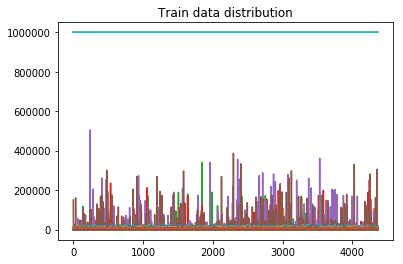

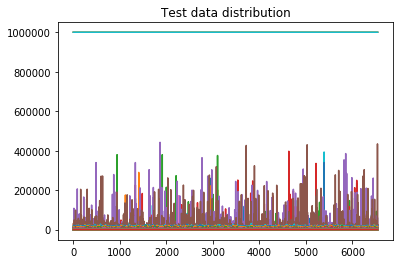

In [3]:
## Visualizes the training_data
plt.plot(train_data_accuracy)
plt.title('Train data distribution')
plt.show()
# mean = np.mean(train_data_accuracy, axis=0)
# std = np.std(train_data_accuracy, axis=0)
# for i in range(len(mean)):
#     print(f'{i}: the mean of the row is {mean[i]}, the variance is {std[i]}')
## Visualizes the test_data
plt.plot(test_data_accuracy)
plt.title('Test data distribution')
plt.show()
# mean = np.mean(test_data_accuracy, axis=0)
# std = np.std(test_data_accuracy, axis=0)
# for i in range(len(mean)):
#     print(f'{i}: the mean of the row is {mean[i]}, the variance is {std[i]}')

#### Observations
As we can see the training data nor the test data are normalized. In addition to it, labels are not equally distribuited: indeed there are more label of class 1 (almost 50%), Pop_Rock, then any other classes as we can see in the cell below. The figure below represents the occurence (in %) of each label.

Label 1 (Pop_Rock): 49.92%
Label 2 (Electronic): 14.16%
Label 3 (Rap): 7.47%
Label 4 (Jazz): 5.8%
Label 5 (Latin): 4.9%
Label 6 (RnB): 5.96%
Label 7 (International): 3.23%
Label 8 (Country): 4.47%
Label 9 (Reggae): 2.11%
Label 10 (Blues): 1.97%


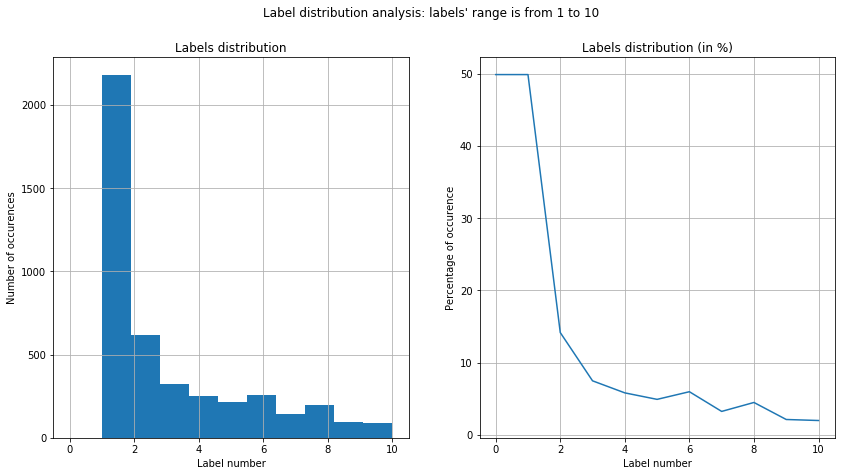

In [10]:
## Visualizes the labels
## Store the music genres that will be printed out
class_names = ['Pop_Rock', 'Electronic', 'Rap', 'Jazz', 'Latin', 'RnB', 'International', 'Country', 'Reggae', 'Blues']
data = np.empty((11, 2))
for i in range(1, 11, 1):
    print(f'Label {i} ({class_names[i - 1]}): {round((len(np.where(train_labels_accuracy == i)[0]) / len(train_labels_accuracy)) * 100, 2)}%')
    ## Since arrays are 0-indexed but the first label is 1, initialize the first position of the array using the first label (1)
    ## This is just to create a nice plot, does not have any effect on the algorithm.
    data[0, 0] = 0
    data[0, 1] = round((len(np.where(train_labels_accuracy == 1)[0]) / len(train_labels_accuracy)) * 100, 2)
    data[i, 0] = i
    data[i, 1] = round((len(np.where(train_labels_accuracy == i)[0]) / len(train_labels_accuracy)) * 100, 2)

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14, 7))
ax = axs[0]
ax.hist(train_labels_accuracy)
ax.set_title('Labels distribution')
ax.set_xlabel('Label number')
ax.set_ylabel('Number of occurences')
ax.grid(True)

ax = axs[1]
ax.plot(data[:, 1])
ax.set_title('Labels distribution (in %)')
ax.set_xlabel('Label number')
ax.set_ylabel('Percentage of occurence')
ax.grid(True)


fig.suptitle('Label distribution analysis: labels\' range is from 1 to 10')
plt.show()

### 2. Data manipulation
#### Cleanup
From the plots of the previous section it can be noticed that some columns (205 to 220) contains features whose values are not aligned with the others: so we can eliminate them.  
*Now each song has 248 features instead of 264.*

The difference in the data is easier to see by comparing the previous plot (re-plotted below) and the new plot.


**Note**: after various tests, it was discovered that eliminating the misaligned features had no practical effect on the whole algorithm: indeed, even though the overall accuracy of the model slightly decreased (from 75.83% to 75.43%) the accuracy with the new data (the test data) did not change. For this reason, we will use the complete dataset instead of the modified one.  
This is probably related to the fact the data are centered with mean 0 and standard variation 1, so the misaligned features do not have an high impact on the overall accuracy.

*Feel free to transform the following cell to a code cell to try the algorithms using the resized data set.*

**Note**: since this notebook utlizes scikit-learn tools, as suggested by their documentation it is important to scale the data.
Scaled data have two particular characteristics:
- Their mean is (almost) equal to 0
- Their variance is (almost) equal to 1  

Thus the data are centered around 0. The differences between the raw training data and the centered training data are visible in the plots below.  
By using the StandardScaler() function it is possible to apply the same transformation to both the datasets: training and testing.

The mean of the train data is: -3.9591392478315614e-17, the variance is: 0.9923953268977462
The mean of the test data is: -0.014540757008522483, the variance is: 1.0115121161980416


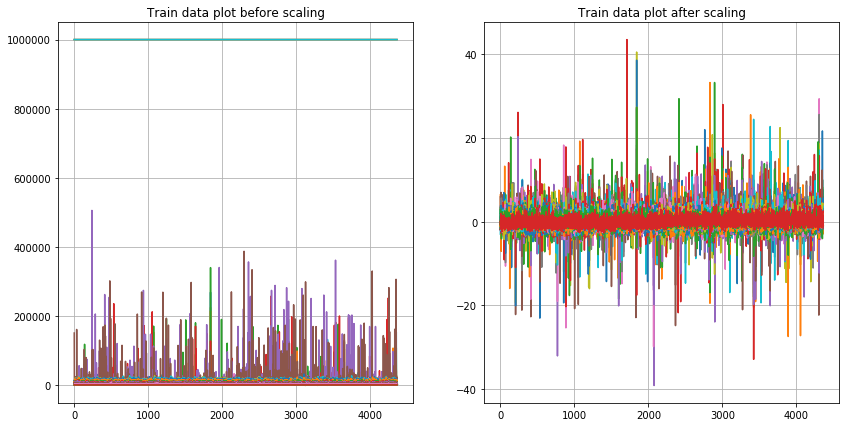

In [27]:
## Scales the data before feeding them into ML algorithms
scaler = preprocessing.StandardScaler().fit(train_data_accuracy)
train_data_scaled = scaler.transform(train_data_accuracy)   
test_data_scaled = scaler.transform(test_data_accuracy)                
print(f'The mean of the train data is: {np.mean(train_data_scaled)}, the variance is: {np.std(train_data_scaled)}')
print(f'The mean of the test data is: {np.mean(test_data_scaled)}, the variance is: {np.std(test_data_scaled)}')
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14, 7))
ax = axs[0]
ax.plot(train_data_accuracy)
ax.set_title('Train data plot before scaling')
ax.grid(True)

ax = axs[1]
ax.plot(train_data_scaled)
ax.set_title('Train data plot after scaling')
ax.grid(True)

### 3. ML Algorithm
After data cleanup, it is time to implement the ML algorithms to predict the labels. For this purpose, this notebook uses *SVM - Support Vector Machine* and *RF - Random Forest*.
The notebook starts with the SVM, then the RTF is implemented.  
It is important to notice that both algorithms use the same data

In [41]:
## Use the standard parameters excepts for the class weight
clf = svm.SVC(gamma='scale', tol=0.001)
clf.fit(train_data_scaled, np.ravel(train_labels_accuracy))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Calculate the accuracy of the algorithm

In [42]:
score = clf.score(train_data_scaled, train_labels_accuracy)
print(f'Algorithm accuracy is {np.round(score * 100, 2)}%')

Algorithm accuracy is 75.43%


The following cell displays the result of the ML algorithm: the blue line represent the training labels and the red lines the predicted one. They should have a similar pattern, although if they are (almost) perfectly aligned, the model is probably overfitting.

Label 1 (Pop_Rock): 71.97%
Label 2 (Electronic): 12.9%
Label 3 (Rap): 7.75%
Label 4 (Jazz): 3.91%
Label 5 (Latin): 0.31%
Label 6 (RnB): 2.19%
Label 7 (International): 0.0%
Label 8 (Country): 0.47%
Label 9 (Reggae): 0.5%
Label 10 (Blues): 0.0%


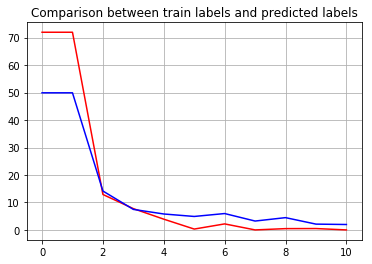

In [43]:
predictions = clf.predict(test_data_scaled)
data_p = np.empty((11, 2))
for i in range(1, 11, 1):
    print(f'Label {i} ({class_names[i - 1]}): {round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)}%')
    # Since arrays are 0-indexed but the first label is 1, initialize the first position of the array using the first label (1)
    # This is just to create a nice plot, does not have any effect on the algorithm.
    data_p[0, 0] = 0
    data_p[0, 1] = round((len(np.where(predictions == 1)[0]) / len(predictions)) * 100, 2)
    data_p[i, 0] = i
    data_p[i, 1] = round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)

plt.plot(data_p[:, 1], c='red')
plt.plot(data[:, 1], c='blue')
plt.grid(True)
plt.title('Comparison between train labels and predicted labels')
plt.show()

The following cell is just a small utility function to save the predicted labels (contained in the pred array) to a csv file that follows the specification.

In [44]:
def save_prediction(pred, filename):
    prediction = pd.DataFrame(pred, columns=['Sample_label'])
    prediction.index += 1 
    prediction.to_csv(f'{filename}.csv',index_label="Sample_id",index=1)
    
save_prediction(predictions, 'SVM')

### RTF - Random Tree Forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
rtf = RandomForestClassifier(n_estimators=10, criterion='gini', verbose=1)
rtf.fit(train_data_accuracy, np.ravel(train_labels_accuracy))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [53]:
score = rtf.score(train_data_accuracy, train_labels_accuracy)
print(f'Algorithm accuracy is {np.round(score * 100, 2)}%')

Algorithm accuracy is 98.37%


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


Label 1 (Pop_Rock): 73.35%
Label 2 (Electronic): 11.6%
Label 3 (Rap): 7.12%
Label 4 (Jazz): 2.8%
Label 5 (Latin): 1.1%
Label 6 (RnB): 2.35%
Label 7 (International): 0.24%
Label 8 (Country): 0.86%
Label 9 (Reggae): 0.46%
Label 10 (Blues): 0.12%


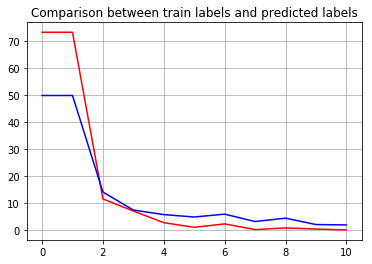

In [55]:
predictions = rtf.predict(test_data_accuracy)
data_p = np.empty((11, 2))
for i in range(1, 11, 1):
    print(f'Label {i} ({class_names[i - 1]}): {round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)}%')
    data_p[0, 0] = 0
    data_p[0, 1] = round((len(np.where(predictions == 1)[0]) / len(predictions)) * 100, 2)
    data_p[i, 0] = i
    data_p[i, 1] = round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)

plt.plot(data_p[:, 1], c='red')
plt.plot(data[:, 1], c='blue')
plt.grid(True)
plt.title('Comparison between train labels and predicted labels')
plt.show()

## Export the calculated predictions
save_prediction(predictions, 'Tree')

#### Bonus content
In this last section about accuracy, the notebook contains the implementation of a Neural Network.  
The Neural Network uses the MLPClassifier function from scikit-learn tools: it is composed of two hidden layers of size ten each, plus one input and one output layer.  
The early stopping technique is used to prevent overfitting.
The algorithm tries to optimize the loss function in every epoch (maximum 1000) and stops when the loss does not improve more than 0.000001 for more than ten consecutive epochs.

In [56]:
from sklearn.neural_network import MLPClassifier

In [59]:
mlp = MLPClassifier(activation='relu',
                    alpha=0.0001,
                    hidden_layer_sizes=(100, 100),
                    learning_rate='constant',
                    max_iter=1000,
                    shuffle=True,
                    solver='adam',
                    tol=0.000001,
                    verbose=True,
                    early_stopping=True
                    )
mlp.fit(train_data_scaled, np.ravel(train_labels_accuracy))

Iteration 1, loss = 1.67599778
Validation score: 0.556064
Iteration 2, loss = 1.28954252
Validation score: 0.608696
Iteration 3, loss = 1.15450929
Validation score: 0.622426
Iteration 4, loss = 1.06673645
Validation score: 0.629291
Iteration 5, loss = 0.99347785
Validation score: 0.629291
Iteration 6, loss = 0.93617349
Validation score: 0.640732
Iteration 7, loss = 0.88727320
Validation score: 0.645309
Iteration 8, loss = 0.83915911
Validation score: 0.654462
Iteration 9, loss = 0.79285387
Validation score: 0.647597
Iteration 10, loss = 0.75474524
Validation score: 0.647597
Iteration 11, loss = 0.71264920
Validation score: 0.649886
Iteration 12, loss = 0.67898673
Validation score: 0.654462
Iteration 13, loss = 0.63866817
Validation score: 0.647597
Iteration 14, loss = 0.60688306
Validation score: 0.640732
Iteration 15, loss = 0.56982160
Validation score: 0.647597
Iteration 16, loss = 0.53944875
Validation score: 0.645309
Iteration 17, loss = 0.51109156
Validation score: 0.640732
Iterat

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=1e-06,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [60]:
score = mlp.score(train_data_scaled, train_labels_accuracy)
print(f'Algorithm accuracy is {np.round(score * 100, 2)}%')

Algorithm accuracy is 74.47%


Label 1 (Pop_Rock): 63.92%
Label 2 (Electronic): 13.52%
Label 3 (Rap): 7.4%
Label 4 (Jazz): 5.47%
Label 5 (Latin): 2.05%
Label 6 (RnB): 3.5%
Label 7 (International): 0.23%
Label 8 (Country): 2.64%
Label 9 (Reggae): 0.95%
Label 10 (Blues): 0.32%


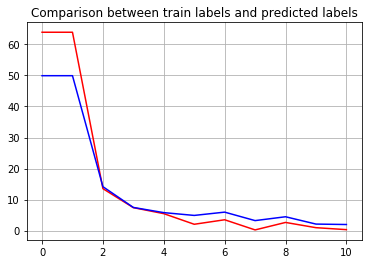

In [62]:
predictions = mlp.predict(test_data_scaled)
data_p = np.empty((11, 2))
for i in range(1, 11, 1):
    print(f'Label {i} ({class_names[i - 1]}): {round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)}%')
    data_p[0, 0] = 0
    data_p[0, 1] = round((len(np.where(predictions == 1)[0]) / len(predictions)) * 100, 2)
    data_p[i, 0] = i
    data_p[i, 1] = round((len(np.where(predictions == i)[0]) / len(predictions)) * 100, 2)

plt.plot(data_p[:, 1], c='red')
plt.plot(data[:, 1], c='blue')
plt.grid(True)
plt.title('Comparison between train labels and predicted labels')
plt.show()

save_prediction(predictions, 'NN')

## Log-loss
After the accuracy challenge, this section is focused on the log-loss challenge.

### Contents
1. Data visualization: how are the raw data provided?
2. Data manipulation
3. ML Algorithm

In [10]:
# Libraries are already imported

# Loads the files
test_data_logloss = pd.read_csv('./log-loss/test_data.csv', header=None)
train_data_logloss = pd.read_csv('./log-loss/train_data.csv', header=None)
train_labels_logloss = pd.read_csv('./log-loss/train_labels.csv', header=None)

# Parse loaded content
test_data_logloss = test_data_logloss.values
train_data_logloss = train_data_logloss.values
train_labels_logloss = train_labels_logloss.values

### 1. Data visualization

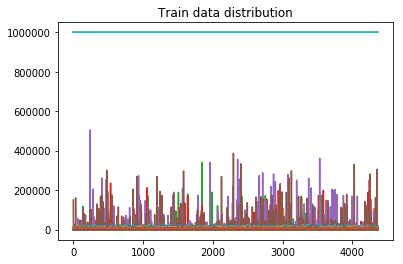

0: the mean of the row is 3097.6837141874857, the variance is 1309.0692857348045
1: the mean of the row is 4390.947407746963, the variance is 1457.4587612355328
2: the mean of the row is 3987.6724648177865, the variance is 1228.0451095791652
3: the mean of the row is 4004.8619963327988, the variance is 1242.1942545491834
4: the mean of the row is 3086.664977538391, the variance is 1030.9023393536486
5: the mean of the row is 3329.8158721063487, the variance is 1124.7167746529087
6: the mean of the row is 3043.6283566353427, the variance is 1097.579688975519
7: the mean of the row is 3034.5740660096267, the variance is 1120.9355528403764
8: the mean of the row is 2671.4632661013065, the variance is 1017.6653200605061
9: the mean of the row is 2440.4640155856064, the variance is 969.9172127780054
10: the mean of the row is 2516.1047536099013, the variance is 1021.0732882824636
11: the mean of the row is 2566.444592940637, the variance is 1116.7614481250025
12: the mean of the row is 3215

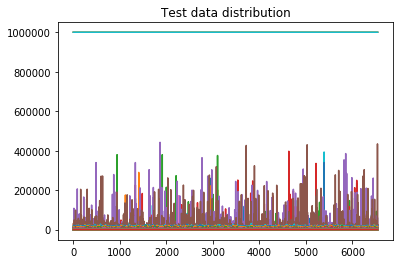

0: the mean of the row is 3058.037015281174, the variance is 1311.1698379910013
1: the mean of the row is 4355.873590158924, the variance is 1486.8149723707027
2: the mean of the row is 3932.126318306846, the variance is 1258.336101811341
3: the mean of the row is 3951.374645782396, the variance is 1250.3599839907881
4: the mean of the row is 3047.5962448044006, the variance is 1034.1695765009956
5: the mean of the row is 3274.0433621638144, the variance is 1134.0023775824293
6: the mean of the row is 3001.383569987775, the variance is 1107.1998411281695
7: the mean of the row is 2985.446799358191, the variance is 1125.6622376587304
8: the mean of the row is 2611.920900061125, the variance is 1004.5212503017566
9: the mean of the row is 2404.7300140586794, the variance is 961.9918696264746
10: the mean of the row is 2486.13600351467, the variance is 1015.6044761497946
11: the mean of the row is 2532.365589700489, the variance is 1106.6088580009318
12: the mean of the row is 3179.235164

In [11]:
# Visualizes the training_data
plt.plot(train_data_logloss)
plt.title('Train data distribution')
plt.show()
mean = np.mean(train_data_logloss, axis=0)
std = np.std(train_data_logloss, axis=0)
for i in range(len(mean)):
    print(f'{i}: the mean of the row is {mean[i]}, the variance is {std[i]}')
# Visualizes the test_data
plt.plot(test_data_logloss)
plt.title('Test data distribution')
plt.show()
mean = np.mean(test_data_logloss, axis=0)
std = np.std(test_data_logloss, axis=0)
for i in range(len(mean)):
    print(f'{i}: the mean of the row is {mean[i]}, the variance is {std[i]}')

#### Observations
As we can see the training data nor the test data are normalized. In addition to it, labels are not equally distribuited: indeed there are more label of class 1 (almost 50%), Pop_Rock, then any other classes as we can see in the cell below. The figure below represents the occurence (in %) of each label.

Label 1 (Pop_Rock): 49.92%
Label 2 (Electronic): 14.16%
Label 3 (Rap): 7.47%
Label 4 (Jazz): 5.8%
Label 5 (Latin): 4.9%
Label 6 (RnB): 5.96%
Label 7 (International): 3.23%
Label 8 (Country): 4.47%
Label 9 (Reggae): 2.11%
Label 10 (Blues): 1.97%


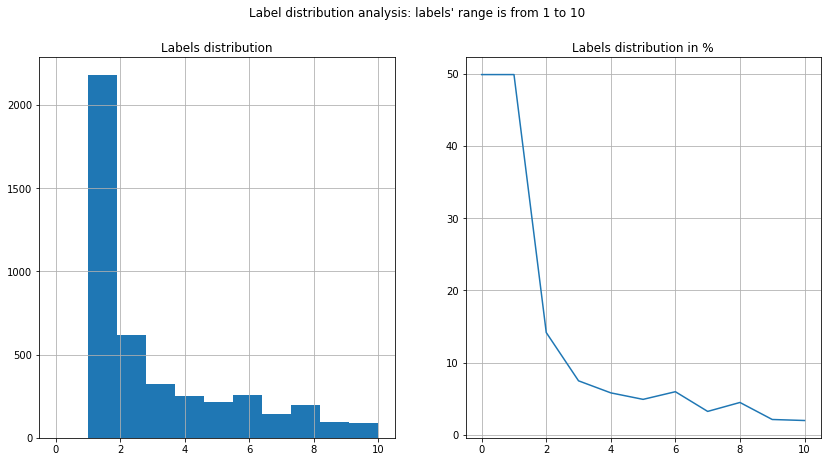

In [12]:
# Visualizes the labels
class_names = ['Pop_Rock', 'Electronic', 'Rap', 'Jazz', 'Latin', 'RnB', 'International', 'Country', 'Reggae', 'Blues']
# Since labels start by 1, in the first position of the data array, I inserted again the value of the first label, to obtain a decent plot
data = np.empty((11, 2))
for i in range(1, 11, 1):
    print(f'Label {i} ({class_names[i - 1]}): {round((len(np.where(train_labels_logloss == i)[0]) / len(train_labels_logloss)) * 100, 2)}%')
    data[0, 0] = 0
    data[0, 1] = round((len(np.where(train_labels_logloss == 1)[0]) / len(train_labels_logloss)) * 100, 2)
    data[i, 0] = i
    data[i, 1] = round((len(np.where(train_labels_logloss == i)[0]) / len(train_labels_logloss)) * 100, 2)

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(14, 7))
ax = axs[0]
ax.hist(train_labels_logloss)
ax.set_title('Labels distribution')
ax.grid(True)

ax = axs[1]
ax.plot(data[:, 1])
ax.set_title('Labels distribution in %')
ax.grid(True)

fig.suptitle('Label distribution analysis: labels\' range is from 1 to 10')
plt.show()

### 2. Data manipulation
#### Cleanup
Some columns (205 to 220) contains features whose values are not aligned with the others: so we can eliminate them.  
*Now each song has 248 features instead of 264.*

In [13]:
# Analysis of the input data
# Feature 1 - 169: Rhythm pattern
# Feature 170 - 217: Chroma
# Feature 218 - 264: MFCCs
# Scales the data before feeding them into ML algorithms
scaler = preprocessing.StandardScaler().fit(train_data_logloss)
train_data_scaled = scaler.transform(train_data_logloss)   
test_data_scaled = scaler.transform(test_data_logloss)                
print(f'The mean of the train data is: {np.mean(train_data_scaled)}, the variance is {np.std(train_data_scaled)}')
print(f'The mean of the test data is: {np.mean(test_data_scaled)}, the variance is {np.std(test_data_scaled)}')

The mean of the train data is: -3.9591392478315614e-17, the variance is 0.9923953268977462
The mean of the test data is: -0.014540757008522483, the variance is 1.0115121161980416


### 3. ML Algorithm
After data cleanup, the algorithm used for the predictions is presented: this notebook uses the SVM - Support Vector Machine - to predict the labels.

In [14]:
clf = svm.SVC(gamma='scale', verbose=True, probability=True)
clf.fit(train_data_scaled, np.ravel(train_labels_logloss))

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [15]:
score = clf.score(train_data_scaled, train_labels_logloss)
print(f'Algorithm accuracy is {np.round(score * 100, 2)}%')

Algorithm accuracy is 75.43%


The shape of the predictions matrix is: (6544, 10)
Average probability for label 1 (Pop_Rock): 4922.98%
Average probability for label 2 (Electronic): 1410.69%
Average probability for label 3 (Rap): 766.72%
Average probability for label 4 (Jazz): 616.93%
Average probability for label 5 (Latin): 506.26%
Average probability for label 6 (RnB): 531.04%
Average probability for label 7 (International): 360.63%
Average probability for label 8 (Country): 448.3%
Average probability for label 9 (Reggae): 209.72%
Average probability for label 10 (Blues): 226.72%


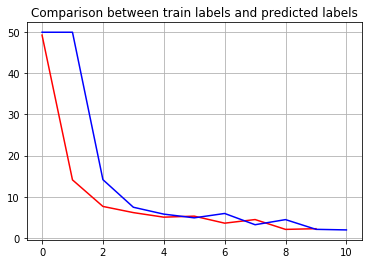

In [16]:
predictions = clf.predict_proba(test_data_scaled)
print(f'The shape of the predictions matrix is: {predictions.shape}')

data_l = np.empty((1, 10))
for i in range(predictions.shape[1]):
    data_l[0, i] = np.mean(predictions[:, i]) * 100
    print(f'Average probability for label {i + 1} ({class_names[i]}): {np.round(data_l[0, i] * 100, 2)}%')

plt.plot(data_l[0, :], c='red')
plt.plot(data[:, 1], c='blue')
plt.grid(True)
plt.title('Comparison between train labels and predicted labels')
plt.show()

In [17]:
def save_prediction_loss(loss):
    prediction = pd.DataFrame(loss,columns=['Class_1','Class_2','Class_3','Class_4','Class_5',
                                            'Class_6','Class_7','Class_8','Class_9','Class_10'])
    prediction.index += 1 
    prediction.to_csv('loss_kaggle.csv',index_label="Sample_id",index=1)
    
save_prediction_loss(predictions)

### Neural Network
This section present another approach, based on a deep Neural Network

In [18]:
from sklearn.neural_network import MLPClassifier

In [19]:
# Set verbose=False to hide training details
mlp = MLPClassifier(activation='relu',
                    alpha=0.0001,
                    hidden_layer_sizes=(100, 100),
                    learning_rate='constant',
                    max_iter=1000,
                    shuffle=True,
                    solver='adam',
                    tol=1e-06,
                    verbose=True
                    )
mlp.fit(train_data_scaled, np.ravel(train_labels_logloss))

Iteration 1, loss = 1.58009408
Iteration 2, loss = 1.26046125
Iteration 3, loss = 1.12960879
Iteration 4, loss = 1.03913510
Iteration 5, loss = 0.96820597
Iteration 6, loss = 0.90480014
Iteration 7, loss = 0.85315428
Iteration 8, loss = 0.80503539
Iteration 9, loss = 0.76228717
Iteration 10, loss = 0.72155516
Iteration 11, loss = 0.68637657
Iteration 12, loss = 0.64867423
Iteration 13, loss = 0.60659654
Iteration 14, loss = 0.57313808
Iteration 15, loss = 0.54589118
Iteration 16, loss = 0.51109059
Iteration 17, loss = 0.48189507
Iteration 18, loss = 0.45342983
Iteration 19, loss = 0.42053928
Iteration 20, loss = 0.39722951
Iteration 21, loss = 0.36707454
Iteration 22, loss = 0.34290336
Iteration 23, loss = 0.31603323
Iteration 24, loss = 0.29351584
Iteration 25, loss = 0.27191675
Iteration 26, loss = 0.25406593
Iteration 27, loss = 0.23372793
Iteration 28, loss = 0.21119840
Iteration 29, loss = 0.19418022
Iteration 30, loss = 0.17756024
Iteration 31, loss = 0.16350675
Iteration 32, los

Iteration 253, loss = 0.00033932
Iteration 254, loss = 0.00033746
Iteration 255, loss = 0.00033522
Iteration 256, loss = 0.00033394
Iteration 257, loss = 0.00033211
Iteration 258, loss = 0.00032944
Iteration 259, loss = 0.00032752
Iteration 260, loss = 0.00032521
Iteration 261, loss = 0.00032343
Iteration 262, loss = 0.00032225
Iteration 263, loss = 0.00032021
Iteration 264, loss = 0.00031813
Iteration 265, loss = 0.00031619
Iteration 266, loss = 0.00031436
Iteration 267, loss = 0.00031278
Iteration 268, loss = 0.00031121
Iteration 269, loss = 0.00030941
Iteration 270, loss = 0.00030749
Iteration 271, loss = 0.00030615
Iteration 272, loss = 0.00030471
Iteration 273, loss = 0.00030337
Iteration 274, loss = 0.00030144
Iteration 275, loss = 0.00030006
Iteration 276, loss = 0.00029841
Iteration 277, loss = 0.00029688
Iteration 278, loss = 0.00029569
Iteration 279, loss = 0.00029419
Iteration 280, loss = 0.00029275
Iteration 281, loss = 0.00029142
Iteration 282, loss = 0.00029011
Iteration 

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=1e-06,
       validation_fraction=0.1, verbose=True, warm_start=False)

In [20]:
nn_score = mlp.score(train_data_scaled, train_labels_logloss)
print(f'Algorithm accuracy is {np.round(nn_score * 100, 2)}%')

Algorithm accuracy is 100.0%


The shape of the predictions matrix is: (6544, 10)
Average probability for label 1 (Pop_Rock): 5275.57%
Average probability for label 2 (Electronic): 1381.5%
Average probability for label 3 (Rap): 713.36%
Average probability for label 4 (Jazz): 639.28%
Average probability for label 5 (Latin): 434.15%
Average probability for label 6 (RnB): 506.79%
Average probability for label 7 (International): 286.2%
Average probability for label 8 (Country): 454.93%
Average probability for label 9 (Reggae): 164.64%
Average probability for label 10 (Blues): 143.57%


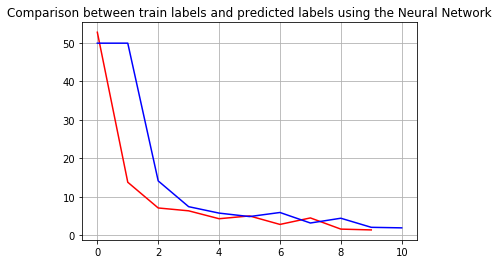

In [21]:
nn_predictions = mlp.predict_proba(test_data_scaled)
print(f'The shape of the predictions matrix is: {nn_predictions.shape}')

data_l_nn = np.empty((1, 10))
for i in range(nn_predictions.shape[1]):
    data_l_nn[0, i] = np.mean(nn_predictions[:, i]) * 100
    print(f'Average probability for label {i + 1} ({class_names[i]}): {np.round(data_l_nn[0, i] * 100, 2)}%')

plt.plot(data_l_nn[0, :], c='red')
plt.plot(data[:, 1], c='blue')
plt.grid(True)
plt.title('Comparison between train labels and predicted labels using the Neural Network')
plt.show()

In [25]:
def save_prediction_loss_nn(loss):
    prediction = pd.DataFrame(loss,columns=['Class_1','Class_2','Class_3','Class_4','Class_5',
                                            'Class_6','Class_7','Class_8','Class_9','Class_10'])
    prediction.index += 1 
    prediction.to_csv('loss_kaggle_nn.csv',index_label="Sample_id",index=1)
    
save_prediction_loss_nn(nn_predictions)

## 4. Results

*Summarize the results of the experiments without discussing their implications.*

*- Include both performance measures (accuracy and LogLoss).*

*- How does it perform on kaggle compared to the train data.*

*- Include a confusion matrix.*



In [22]:
#Confusion matrix ...

## 5. Discussion/Conclusions

*Interpret and explain your results *

*- Discuss the relevance of the performance measures (accuracy and LogLoss) for
imbalanced multiclass datasets. *

*- How the results relate to the literature. *

*- Suggestions for future research/improvement. *

*- Did the study answer your questions? *



## 6. References

*List of all the references cited in the document*

## Appendix
*Any additional material needed to complete the report can be included here. For example, if you want to keep  additional source code, additional images or plots, mathematical derivations, etc. The content should be relevant to the report and should help explain or visualize something mentioned earlier. **You can remove the whole Appendix section if there is no need for it.** *